# Exploring the UTx000 Extension Beacon Data
(See the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Ventilation Rates - A Deeper Look
After having estimated ventilation rates using the constant and decay methods, we can start to look at the values that were calculated more deeply. 

## Package Import

In [2]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import math
import statsmodels.api as sm
import scipy.optimize

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Data Import

In [3]:
data_dir = "../data"
study = "utx000"
suffix = "ux_s20"

## Ventilation Rates
Now the ventilation rates are imported. We import all available data, but primarily care about the last dataset:
* `ach_from_ss`: ventilation from steady-state analysis
* `ach_from_decay`: ventilation from decay method analysis
* `ach`: previous two datasets combined with less information

In [4]:
ach_from_ss = pd.read_csv(f"../data/processed/beacon-ventilation_from_ss.csv")
ach_from_decay = pd.read_csv(f"../data/processed/beacon-ventilation_from_decay.csv")
ach = pd.read_csv(f"../data/processed/beacon-ventilation.csv",parse_dates=["start","end"],infer_datetime_format=True)
ach.head()

,beacon,beiwe,start,end,ach,method
0,21.0,lkkjddam,2020-08-12 13:16:00,2020-08-12 13:38:00,0.151,decay
1,21.0,lkkjddam,2020-08-16 13:36:00,2020-08-16 14:08:00,0.143,decay
2,21.0,lkkjddam,2020-08-18 12:48:00,2020-08-18 13:22:00,0.202,decay
3,21.0,lkkjddam,2020-08-20 12:26:00,2020-08-20 12:52:00,0.078,decay
4,21.0,lkkjddam,2020-08-20 14:14:00,2020-08-20 14:44:00,0.062,decay


# Analysis

## Multiple Ventilation Rates
There are nights when we get multiple measurements of ventilation for the same participant so we want to check those out. If the values are similar, we should just average the measurements for that evening.

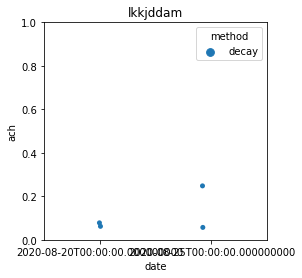

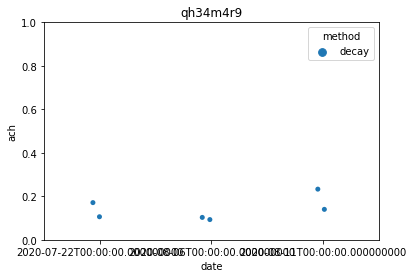

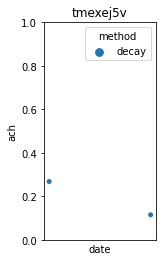

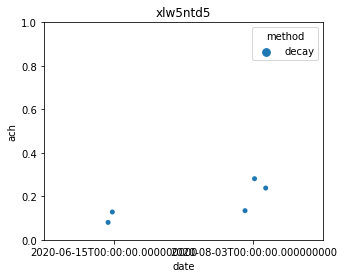

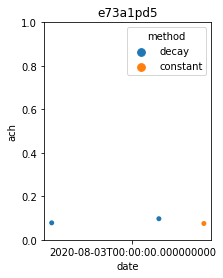

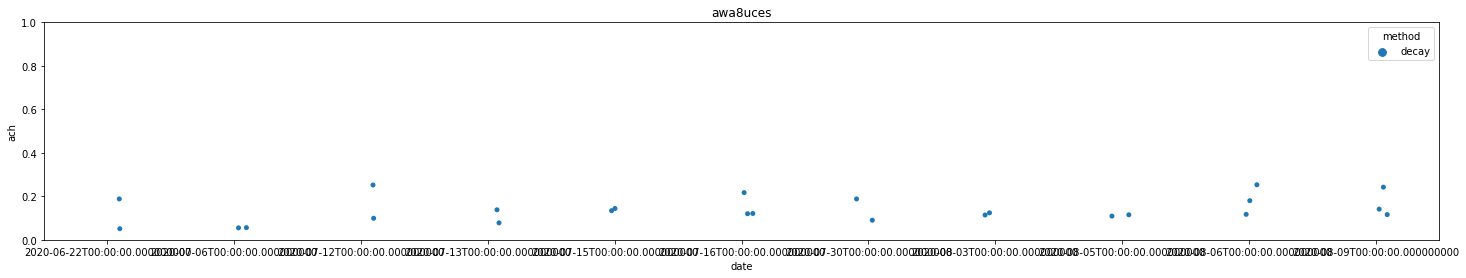

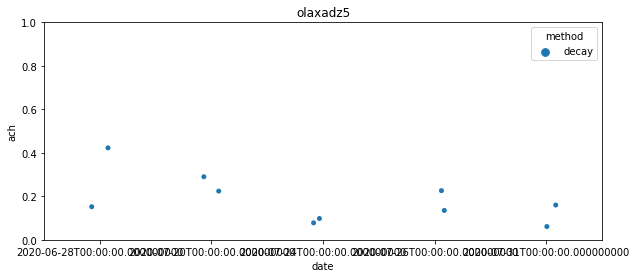

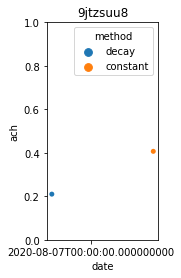

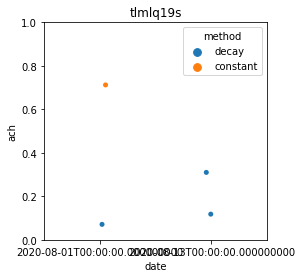

In [5]:
plot=True
ach["date"] = pd.to_datetime(ach["end"].dt.date)
for pt in ach["beiwe"].unique():
    ach_by_pt = ach[ach["beiwe"] == pt]
    duplicates = ach_by_pt[ach_by_pt.duplicated(subset=["date"], keep=False)]
    if len(duplicates) > 0:
        if plot:
            fig, ax = plt.subplots(figsize=(len(duplicates)*1,4))
            sns.stripplot(x="date",y="ach",hue="method", data=duplicates, ax=ax)
            ax.set_ylim([0,1])
            ax.set_title(pt)
            plt.show()
            plt.close()

<div class="alert alert-block alert-warning">
    
Kerry suggested that we look at the median ventilation rate rather than the mean, but given that we primarily only have two points per night, the mean makes more sense.
    
</div>

In [6]:
ach_summarized = ach.groupby(["beiwe","date","method"]).mean().reset_index()
ach_summarized.head()

,beiwe,date,method,beacon,ach
0,745vq78e,2020-06-19,constant,5.0,0.276791
1,745vq78e,2020-06-20,constant,5.0,0.263552
2,745vq78e,2020-06-26,constant,5.0,0.229769
3,745vq78e,2020-07-03,constant,5.0,0.307218
4,745vq78e,2020-07-21,constant,5.0,0.315266


# Visualizing
Now that we have values per night per method, we can plot the resulting ventilation rates

## Calculated Rates

In [11]:
def plot_strip(df,save=False):
    """Plots strip plots of ventilation rates"""
    
    fig, ax = plt.subplots(figsize=(10,6))
    df_to_plot = df.copy()
    device_no = []
    for bb in df_to_plot["beacon"]:
        if bb < 10:
            device_no.append("0"+str(int(bb)))
        else:
            device_no.append(str(int(bb)))

    df_to_plot["device"] = device_no
    df_to_plot.sort_values("device",inplace=True)
    df_to_plot["method_title"] = ["Decay" if method == "decay" else "Steady-State" for method in df_to_plot["method"]]
    sns.stripplot(x="device",y="ach",hue="method_title",palette=['#333f48','#bf5700'],size=8,jitter=0.2,data=df_to_plot,ax=ax)
    # xlabel
    ax.set_xlabel("Device Number",fontsize=18)
    plt.xticks(fontsize=14)
    # ylabel
    ax.set_ylabel("Ventilation Rate (h$^{-1}$)",fontsize=18)
    plt.yticks(fontsize=14)
    # other
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    ax.legend(frameon=False,title="Estimation Method",fontsize=13,title_fontsize=16)

    if save:
        plt.savefig("../reports/figures/beacon_summary/ventilation_rates-strip-ux_s20.pdf",bbox_inches="tight")
        
    plt.show()
    plt.close()

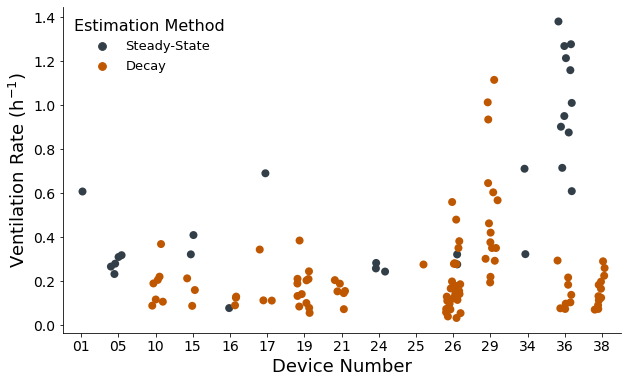

In [12]:
plot_strip(ach_summarized, save=True)

## Relationship between CO$_2$ and Ventilation Rates
There should be a relationship between the ventilation rates we calculated and the CO$_2$ concentration.

### Importing and Processing Beacon Data
We import the beacon data from the evenings and aggregate the measuremenst based on the sleep period.

In [116]:
beacon_nightly = pd.read_csv('../data/processed/beacon-fb_and_gps_filtered-ux_s20.csv',
                    index_col="timestamp",parse_dates=["timestamp","start_time","end_time"],infer_datetime_format=True)
beacon_short = beacon_nightly[[column for column in beacon_nightly.columns if column in ["beacon","beiwe","redcap","end_time","co2"]]]
beacon_short["date"] = pd.to_datetime(beacon_short["end_time"].dt.date)
beacon_summarized = beacon_short.groupby(["beiwe","date"]).median().reset_index()
ach_and_co2 = ach_summarized.merge(right=beacon_summarized,on=["beiwe","beacon","date"])
ach_and_co2.head()

,beiwe,date,method,beacon,ach,co2,redcap
0,kyj367pi,2020-07-21,constant,1.0,0.608224,959.685559,10
1,745vq78e,2020-06-19,constant,5.0,0.276791,1455.960268,55
2,745vq78e,2020-06-20,constant,5.0,0.263552,1571.206748,55
3,745vq78e,2020-06-26,constant,5.0,0.229769,1653.628547,55
4,745vq78e,2020-07-03,constant,5.0,0.307218,1352.252022,55


### Scattering Results to Look for Trends
We create a basic plot to investigate if the relationship holds

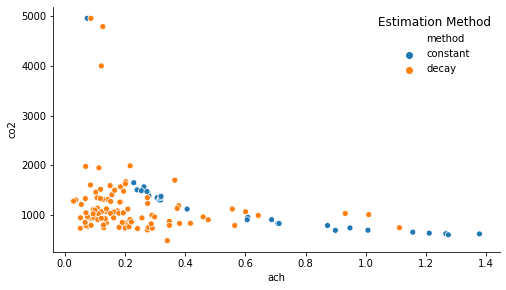

In [191]:
fig, ax = plt.subplots(figsize=(8,4.5))
sns.scatterplot(x="ach",y="co2",hue="method",data=ach_and_co2,ax=ax)
for loc in ["top","right"]:
    ax.spines[loc].set_visible(False)
    
ax.legend(frameon=False,title="Estimation Method",title_fontsize=12)
plt.show()
plt.close()

<div class="alert alert-block alert-success">
    
Looking at jsut the `constant` estimation method, there is a noticeable trend that appears to be like an exponential decay. The same relationship _appears_ to be true when considering the `decay` method, but with a lot of noise and low `co2` and `ach` levels.
    
</div>

### Fitting Exponential Decay Model

$
f(x) = ae^{-xt} + k
$

We can fit two types of exponential models:
1. General Model
2. General Model with fixed asymptote at background concentration (k=400)

#### Eponential Decay Model Functions

In [209]:
def decay(x, a, t, k):
    """General exponential decay function"""
    return a * np.exp(-t * x) + k

In [210]:
def decay_background_intercept(x, a, t):
    """Exponential decay function with asymptote at 400 for background CO2 concentration"""
    return a * np.exp(-t * x) + 400

#### Fitting

In [211]:
def fit_exponential_curve(xs,ys,decay_model, init=[5000, 5, 400], plot=True):
    """Performs exponential decay fit"""
    try:
        params, cv = scipy.optimize.curve_fit(decay_model, xs, ys, init)
        a, t, k = params
    except TypeError: # decay with pre-set asymptote
        params, cv = scipy.optimize.curve_fit(decay_model, xs, ys, init[:-1])
        a, t = params
        k = 400

    # plot the results
    if plot:
        plt.plot(xs, ys, '.', label="data")
        plt.plot(np.linspace(0,1.6,100), a * np.exp(-t * np.linspace(0,1.6,100)) + k, '--', label="fitted")
        plt.title("Fitted Exponential Curve")
        
    return a, b, k

(8089.668330649351, 757.7347074346351, 757.7339285953918)

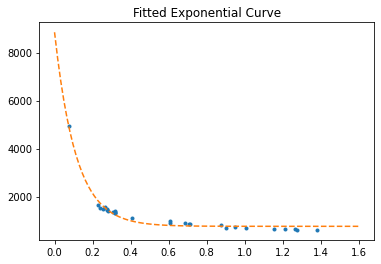

In [208]:
data = ach_and_co2[ach_and_co2["method"] == "constant"].sort_values("co2",ascending=False)
xs = data["ach"].values
ys = data["co2"].values
fit_exponential_curve(xs,ys,decay)